## A1: Research Question

This analysis will aim to answer the research question: "What factors significantly contribute to customer churn?" Mitigating churn rate is critical for every business, and understanding the driving factors is a critical first step to implementing effective reduction strategies. Identifying these factors can provide critical information related to the organization's problem or success areas.

## A2: Goal of Analysis

The goal of this analysis is to understand the key factors behind customer churn rate. Identification of these factors will allow the organization to effectively allocate resources towards customer retention and revamp policies or services that are affiliated with customer churn. If certain features are linked to high churn rates, such as customer location, it can pinpoint where market analysis may be required; perhaps a new competitor in that area offers better pricing or services. Conversely, if features stand out by having little or no churn associated with them, such as monthly charges, it could be that those customers are on legacy service plans and pricing that are grandfathered. Regardless of the outcome of this analysis, the organization will benefit as even failure to identify any significant features still provides insight into the next steps. In this scenario, it can indicate that the current data collection is insufficient and should be expanded.

## B1: Assumptions of Logistic Regression

This analysis will use logistic regression to understand the relationship between the predictor variables and our target variable, customer churn. This model has several assumptions: the response variable is binary, severe multicollinearity is not present such that each predictor variable is not highly correlated with another, each observation is independent and not influenced by another observation, and there are no extreme outliers in the dataset. If any of these assumptions are false within our dataset, then the model's result may be unreliable (Zach, 2020).

## B2: Benefits of Python for Analysis

Python is a general-purpose programming language that can be used for a variety of purposes. It has a plethora of available libraries and packages that support all stages of data analysis. Furthermore, the syntax of the language is standardized. This reduces the learning curve when utilizing third-party libraries, and time is not wasted learning arbitrary syntax implementation differences.

## B3: Justification of Logistic Regression

Logistic regression is necessary for this analysis as our target variable, churn, is binary being that it only exists as Yes/No in our dataset.


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, zscore

df = pd.read_csv("churn_clean.csv", index_col=0, na_filter=False)
df.columns = df.columns.str.lower()

if df.isna().sum().sum() > 0 or df.duplicated().sum() > 0:
    raise ValueError("There are missing values or dulpicated rows in the dataframe")

# Set correct data types
df[["zip", "item1", "item2", "item3", "item4", "item5", "item6", "item7", "item8"]] = (
    df[
        ["zip", "item1", "item2", "item3", "item4", "item5", "item6", "item7", "item8"]
    ].astype("object")
)

outliers = pd.DataFrame()

# Detect outliers
for col in df.select_dtypes([np.number]).columns:
    z = np.abs(zscore(df[col]))
    outliers[col] = z > 3


def cap_outliers(series: pd.Series) -> pd.Series:
    """Cap outliers to the 1st and 99th percentiles."""
    lower_bound = series.quantile(0.01)
    upper_bound = series.quantile(0.99)
    return series.clip(lower_bound, upper_bound)


# Clip identified outliers
for col in outliers.columns:
    mask = outliers[col]
    df.loc[mask, col] = cap_outliers(df[col])

## C1: Data Cleaning

The data cleaning goals for the logistic regression analysis at this stage are to handle missing values, set correct column datatypes, and identify and treat outliers. The code above performs the cleaning required for further analysis. First, the na_filter is disabled as no values are missing in the raw dataset, but the filter detects the categorical value of "None" as NA. Next, the zip code and survey responses are set to object datatypes as they are initially stored as integers. Outliers are detected by their Z-score, using three as the threshold. Finally, the outliers' result is used to cap their values within the first and 99th percentile.


In [4]:
target = df["churn"]

results = {}
x = []


for col in df.columns[3:]:
    if col == "churn":
        continue
    
    if df[col].dtype == "object":
        chi2, p, *_ = chi2_contingency(pd.crosstab(df[col], target))
        results[col] = {"chi2": chi2, "p_value": p}
    else:
        group = [df[col][target == cat] for cat in target.unique()]
        f_statistic, p_value = f_oneway(*group)
        results[col] = {"f_statistic": f_statistic, "p_value": p_value}


print("Statistically significant columns with p-values:")

for key, value in results.items():
    p = value.get("p_value", 42)
    if p <= 0.05:
        x.append(key)
        print(f"{key}: {p}")

x.extend(["area", "state"])
for col in x:
    if df[col].dtype == "object":
        to_print = df[col].value_counts(True).multiply(100).round(2).astype(str) + "%"
    else:
        to_print = df[col].describe().round(2)
    print("-" * 36)
    print(col, ":", to_print.to_string())
print("-" * 36)
print(
    "churn:",
    (target.value_counts(True).multiply(100).round(2).astype(str) + "%").to_string(),
)

Statistically significant columns with p-values:
gender: 0.019447581193944605
techie: 3.096716355509661e-11
contract: 9.116348157571405e-157
internetservice: 1.0182587025108534e-19
phone: 0.009577996710151358
multiple: 1.605731854232948e-39
onlinebackup: 4.954240771375978e-07
deviceprotection: 1.8431033713742524e-08
streamingtv: 5.5493806313354526e-117
streamingmovies: 1.0780102289761383e-183
paymentmethod: 0.02400702004497883
tenure: 0.0
monthlycharge: 0.0
bandwidth_gb_year: 0.0
------------------------------------
gender : gender
Female       50.25%
Male         47.44%
Nonbinary     2.31%
------------------------------------
techie : techie
No     83.21%
Yes    16.79%
------------------------------------
contract : contract
Month-to-month    54.56%
Two Year          24.42%
One year          21.02%
------------------------------------
internetservice : internetservice
Fiber Optic    44.08%
DSL            34.63%
None           21.29%
------------------------------------
phone : phone
Y

## C2: Summary Statistics

Some of the independent variables were selected based on statistical significance using the Chi-squared and one-way ANOVA tests. Since these variables appear to be statistically significant, they should be evaluated and combined with variables from institutional knowledge. The results of our tests show that gender, techie, contract, internetservice, phone, multiple, onlinebackup, deviceprotection, streamingtv, streamingmovies, paymentmethod, tenure, monthlycharge, and bandwidth_gb_year have a strong relationship to customer churn. The relative frequency of each value is shown for the qualitative columns and the mean, minimum, and maximum values and percentiles are shown for the quantitative columns.

In addition to the statistically significant variables, area and state have been added. These were added to keep the traditional institutional knowledge that would typically be applied and to demonstrate model reduction later. These variables are added in an attempt to identify key markets that can lead to further analysis. The summary statistics for these columns can also be found above.

## C3: Univariate and Bivariate Visualizations

See below.


Univariate Visualizations:


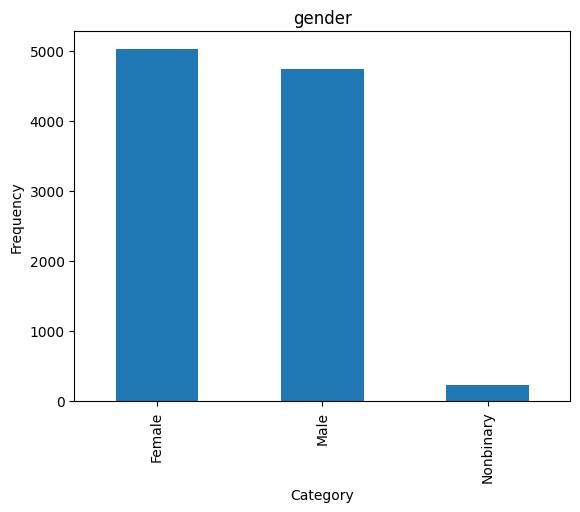

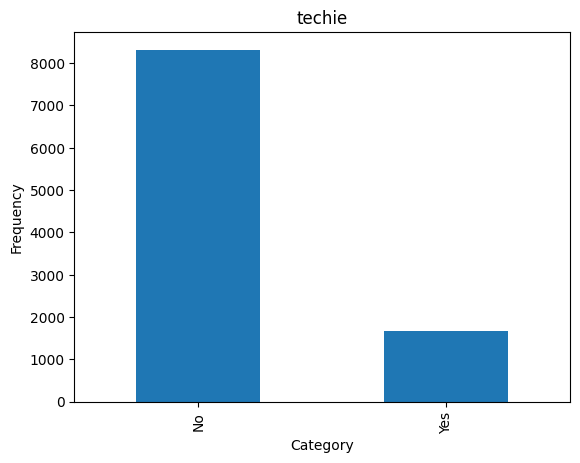

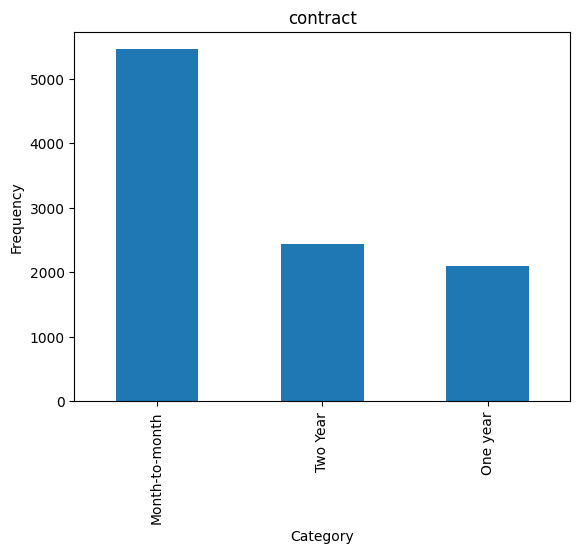

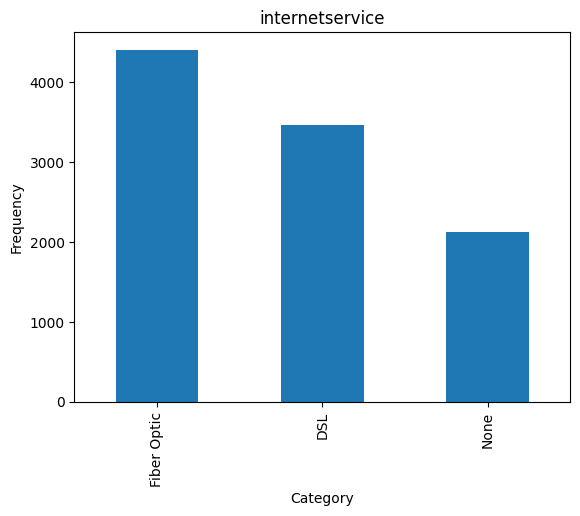

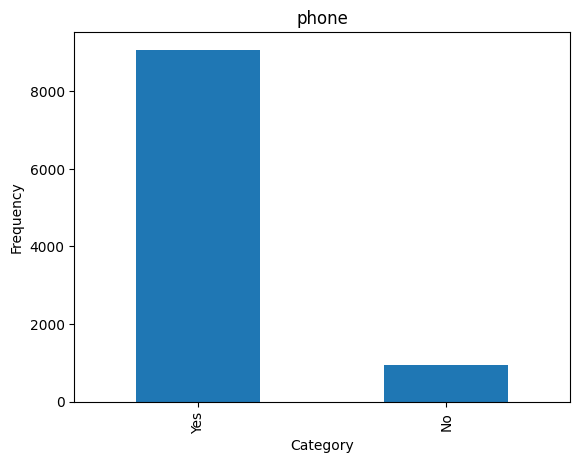

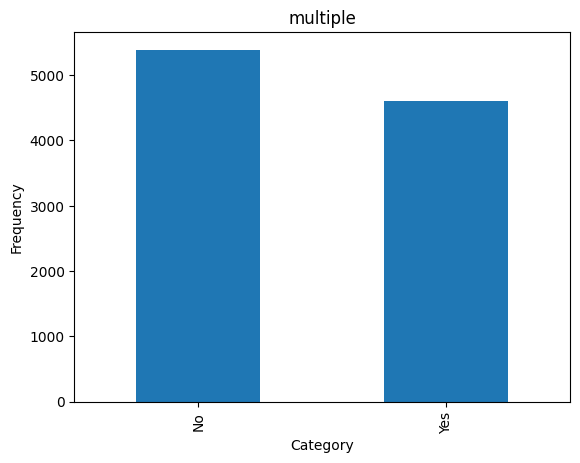

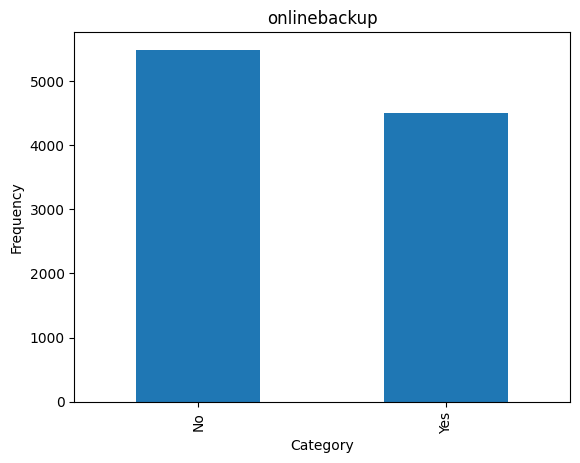

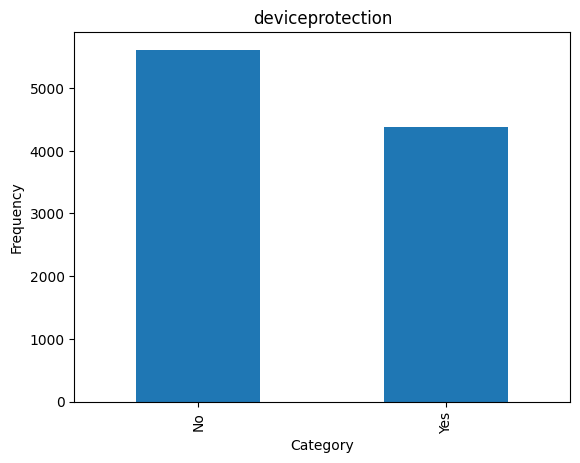

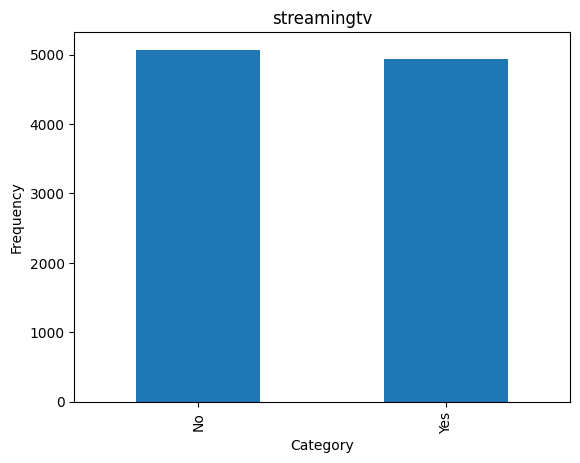

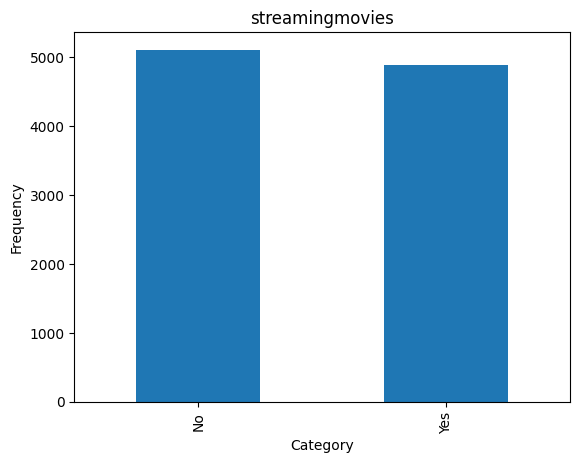

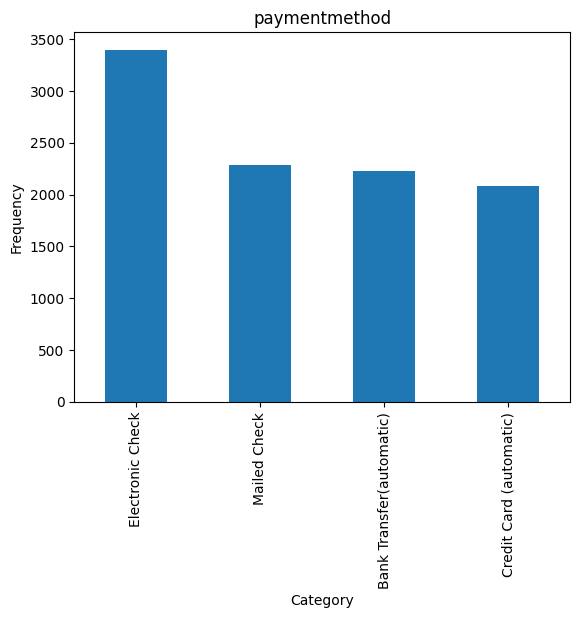

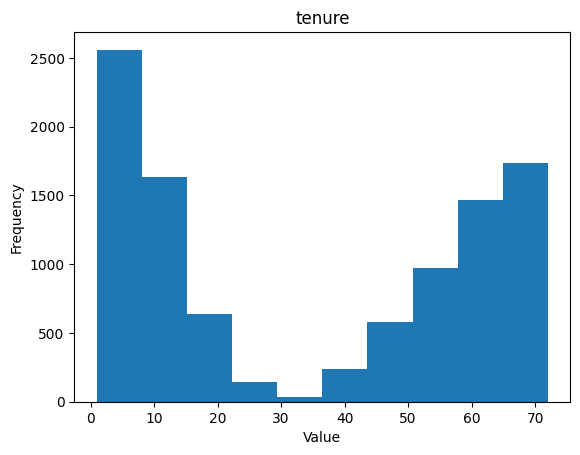

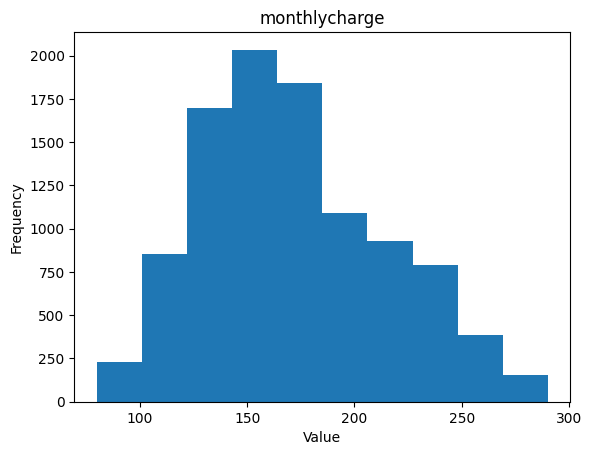

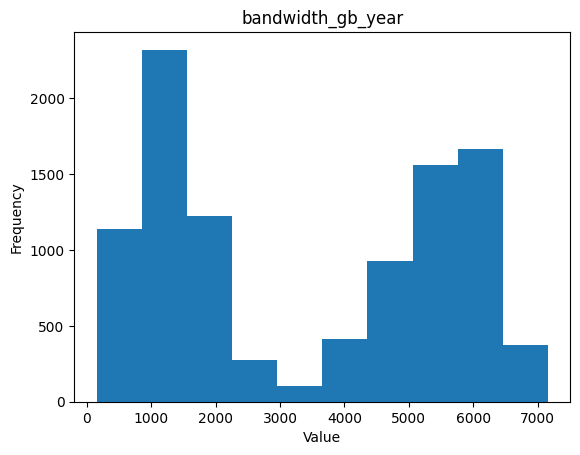

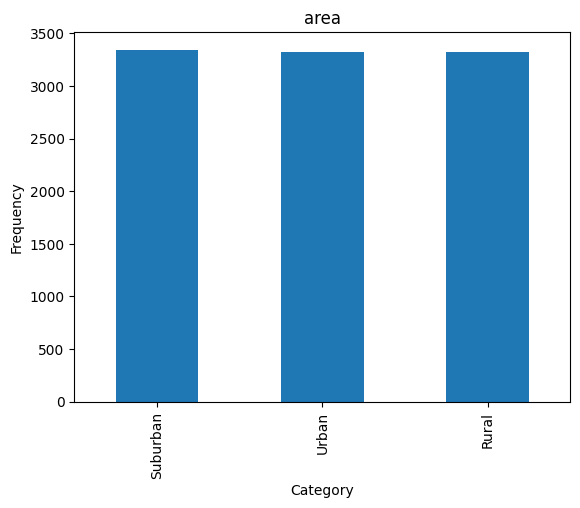

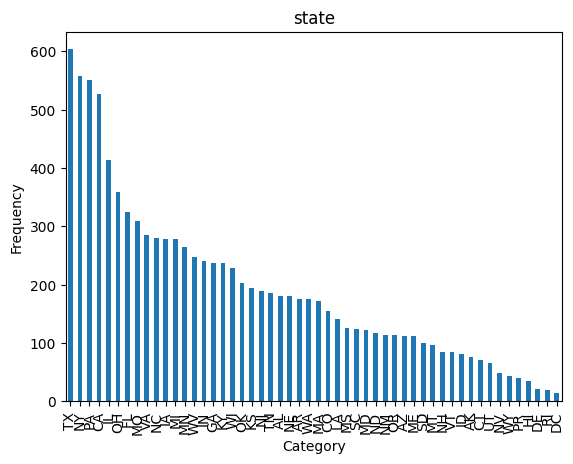

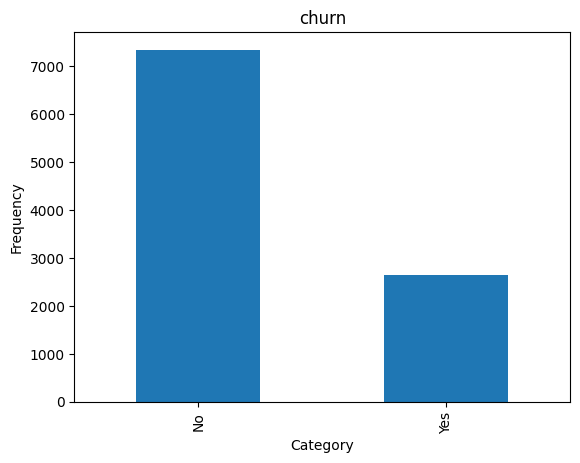

Bivariate Visualizations:


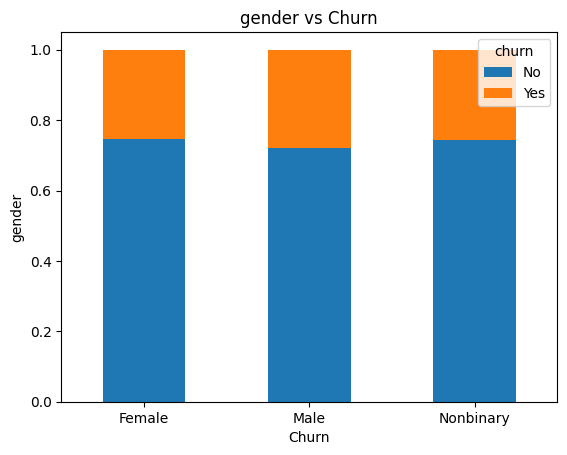

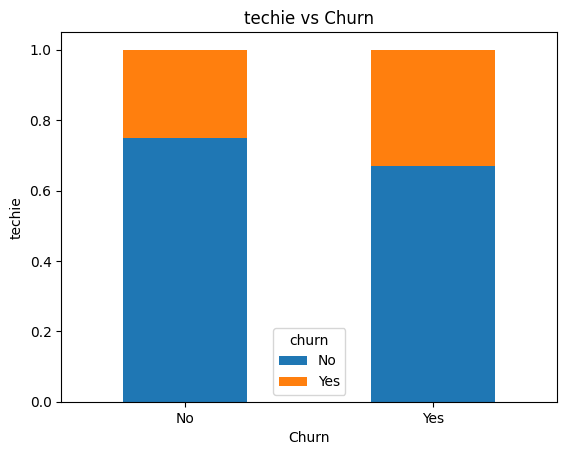

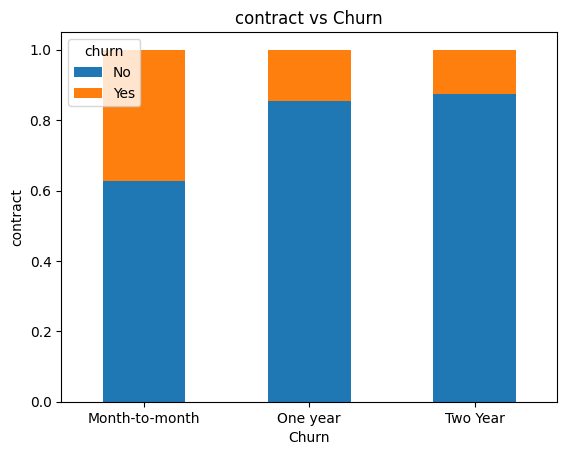

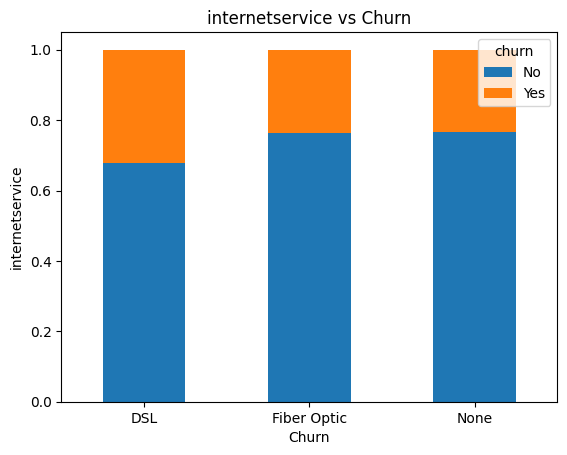

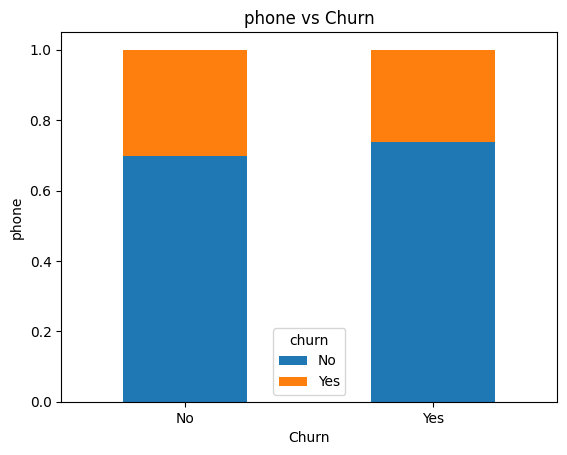

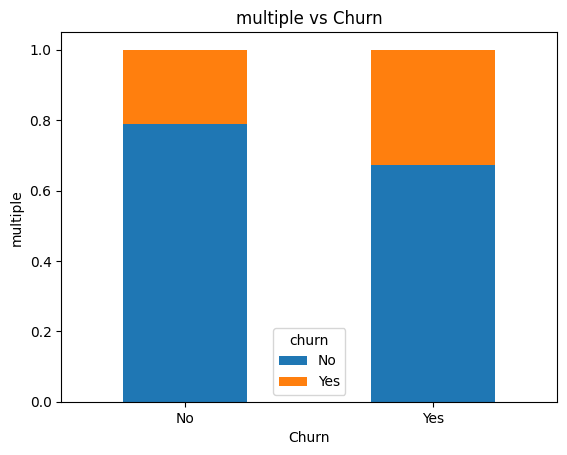

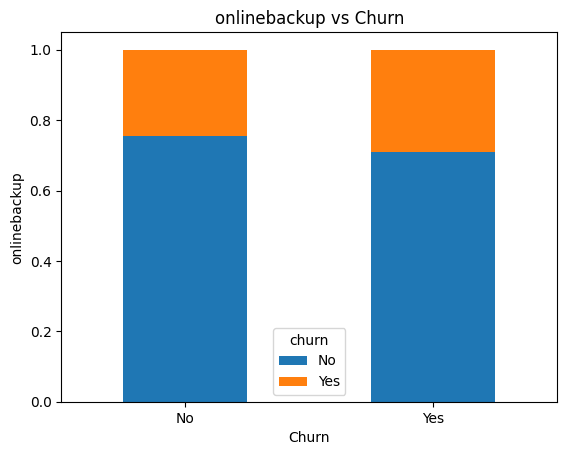

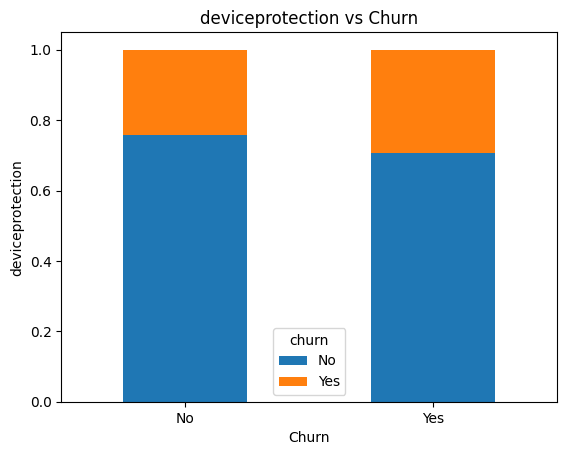

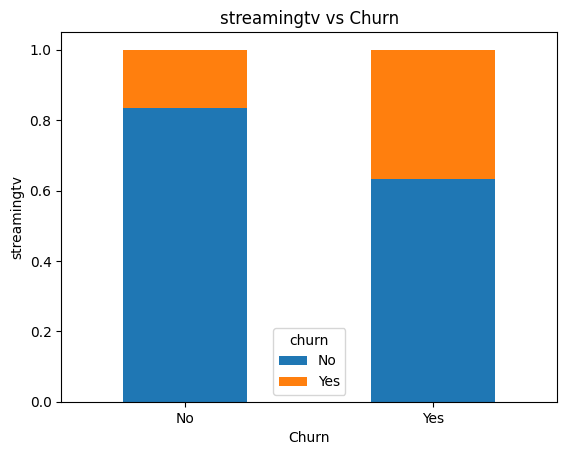

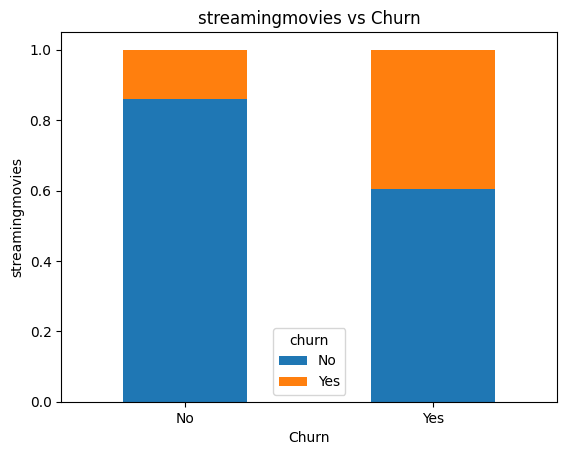

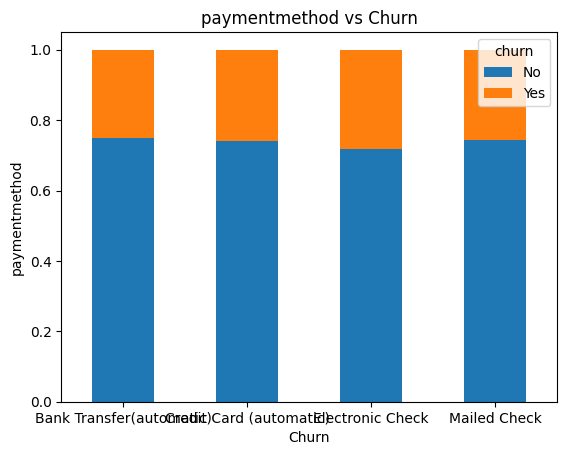

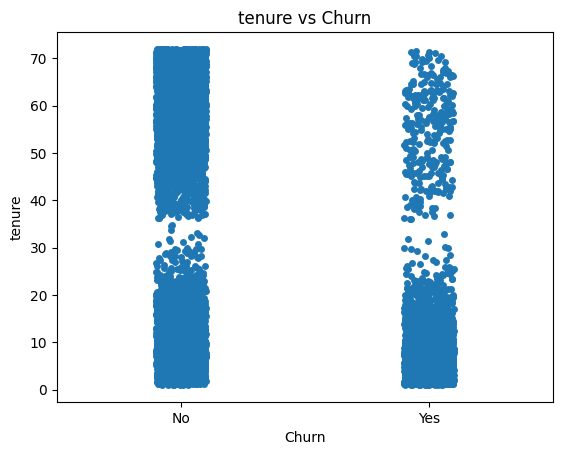

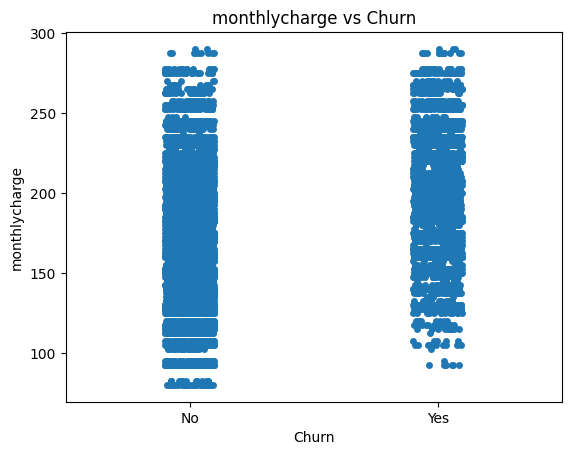

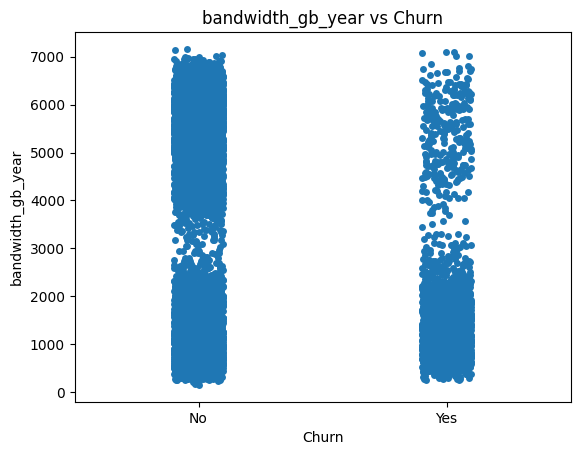

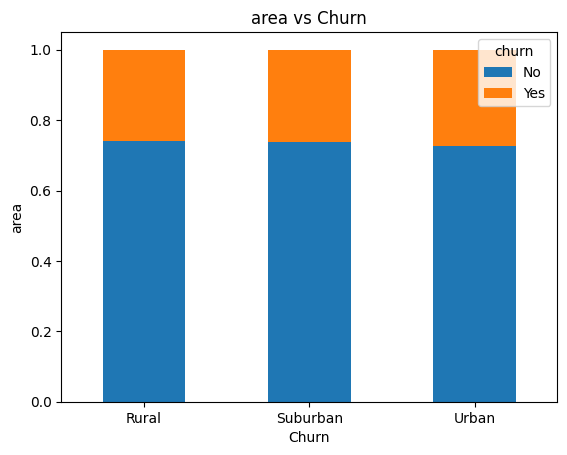

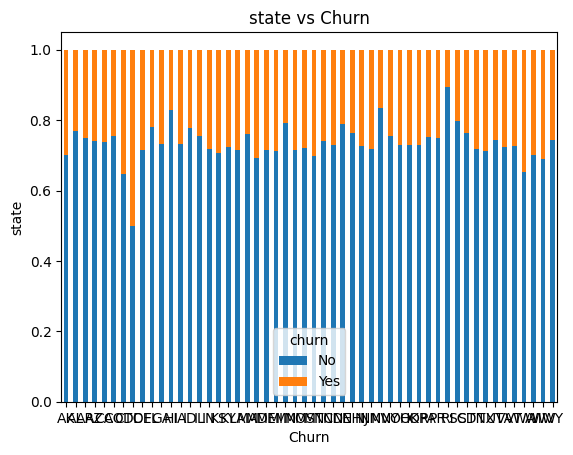

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Univariate Visualizations:")

for col in x + ["churn"]:
    col: str
    if df[col].dtype == "object":
        df[col].value_counts().plot(kind="bar")
    else:
        plt.hist(df[col])
    plt.xlabel("Category" if df[col].dtype == "object" else "Value")
    plt.ylabel("Frequency")
    plt.title(col)
    plt.show()

print("Bivariate Visualizations:")

for col in x:
    if df[col].dtype != "object":
        sns.stripplot(x="churn", y=col, data=df, jitter=True)
    else:
        pd.crosstab(df[col], target, normalize="index").plot(kind="bar", stacked=True)
    plt.xlabel("Churn")
    plt.ylabel(col)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=0)
    plt.show()

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


# Dummy/One-Hot Encoding
X = pd.get_dummies(df[x], drop_first=True)


# Convert values to float
X_float = X.astype(float)

# Calculate and remove features with high VIF scores
while True:
    vif = pd.DataFrame()
    vif["Feature"] = X_float.columns
    vif["VIF"] = [
        variance_inflation_factor(X_float.values, i) for i in range(X_float.shape[1])
    ]

    max_vif = vif["VIF"].max()
    if max_vif > 5:
        feature_to_remove = vif.loc[vif["VIF"].idxmax()]["Feature"]
        print(f"Removing {feature_to_remove} with VIF of {max_vif:.2f}")
        X_float = X_float.drop(columns=[feature_to_remove])
        X = X.drop(columns=[feature_to_remove])
    else:
        break


# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Removing bandwidth_gb_year with VIF of 1484.90
Removing monthlycharge with VIF of 188.89
Removing phone_Yes with VIF of 10.12


## C4: Data Transformation

One of the data transformation goals is creating dummy variables for the categorical columns. This is completed above, and the dummy variable trap is avoided by the drop_first argument. Next, the data is checked for multicollinearity. While this is typically a data cleaning step, the data was initially cleaned before feature selection due to the project's requirements and layout. Performing this step on all columns would not serve a relevant purpose as it could eliminate columns used in the regression model while the correlated independent variable was never selected. Finally, the data is standardized so the coefficients of the regression model are on the same scale and allow for better interpretation.

Important note: due to the project requirements, the data is scaled in this step as data transformation and providing the prepared CSV are required before model creation. Scaling the data before the train-test split can lead to data leakage. Data leakage occurs when information from the training set is leaked into the test set. The scaler is fit to the entire dataset before the split, which can lead to overly optimistic performance when evaluating the model. Given that this issue is due to the project requirements and structure, it will not be further discussed or considered in this report.


## C5: Prepared Dataset

The CSV was submitted alongside this analysis and generated using the code below.


In [7]:
prepared = pd.concat([X, target], axis=1)
prepared.to_csv("cleaned_data_task2.csv", index=False)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def get_model_metrics(y_train, y_test, y_train_pred, y_test_pred):
    print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.5f}")
    print("-" * 36)
    print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred):.5f}")
    print("Testing Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("Testing Classification Report:")
    print(classification_report(y_test, y_test_pred, digits=5))
    print("-" * 36)


# Map target variable
y = target.map({"Yes": 1, "No": 0})

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Model evaluation
initial_y_train_pred = model.predict(X_train)
initial_y_test_pred = model.predict(X_test)

get_model_metrics(y_train, y_test, initial_y_train_pred, initial_y_test_pred)

Training Accuracy: 0.90225
------------------------------------
Testing Accuracy: 0.89750
Testing Confusion Matrix:
[[1365   91]
 [ 114  430]]
Testing Classification Report:
              precision    recall  f1-score   support

           0    0.92292   0.93750   0.93015      1456
           1    0.82534   0.79044   0.80751       544

    accuracy                        0.89750      2000
   macro avg    0.87413   0.86397   0.86883      2000
weighted avg    0.89638   0.89750   0.89679      2000

------------------------------------


## D1: Initial Model

See above.

## D2: Feature Selection Technique Justification

The model will be reduced using the L1 penalty, or Lasso regularization, to perform feature selection. Regularization is a statistical method to reduce errors for overfitting training data by encouraging sparsity in the chosen features. The regularization strength is run across varying points, causing different features to have their coefficients shrunk to zero, effectively removing them from the selection. The tested models' accuracy score is used to choose the best model.

## D3: Reduced Model

See below.


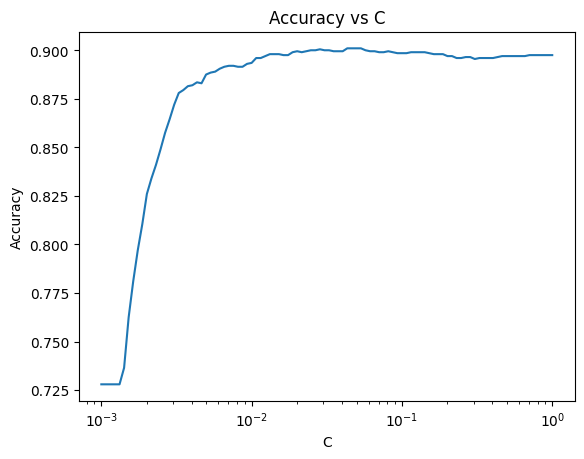

Best C value: 0.04328761281083059
Selected features: tenure, gender_Male, techie_Yes, contract_One year, contract_Two Year, internetservice_Fiber Optic, internetservice_None, multiple_Yes, onlinebackup_Yes, deviceprotection_Yes, streamingtv_Yes, streamingmovies_Yes, paymentmethod_Electronic Check, paymentmethod_Mailed Check, state_DC, state_FL, state_IL, state_LA, state_MT, state_NM, state_NY, state_OR, state_RI, state_SD, state_TN, state_TX, state_VA, state_WI, state_WV
------------------------------------
Training Accuracy: 0.90125
------------------------------------
Testing Accuracy: 0.90100
Testing Confusion Matrix:
[[1371   85]
 [ 113  431]]
Testing Classification Report:
              precision    recall  f1-score   support

           0    0.92385   0.94162   0.93265      1456
           1    0.83527   0.79228   0.81321       544

    accuracy                        0.90100      2000
   macro avg    0.87956   0.86695   0.87293      2000
weighted avg    0.89976   0.90100   0.900

In [9]:
C_values = np.logspace(-3,0,100)
test_accuracy = []

for c in C_values:
    model = LogisticRegression(penalty="l1", solver="saga", max_iter=1000, C=c, n_jobs=-1)
    model.fit(X_train, y_train)
    test_accuracy.append(model.score(X_test, y_test))

plt.plot(C_values, test_accuracy)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Accuracy vs C")
plt.show()


# Get the best model
best_C = C_values[np.argmax(test_accuracy)]
print("Best C value:", best_C)
# Refit to get selected features of the best model
model = LogisticRegression(
    penalty="l1", solver="saga", max_iter=1000, C=best_C, n_jobs=-1
)
model.fit(X_train, y_train)
selected_features = X.columns[model.coef_[0] != 0]
print("Selected features:", ", ".join(selected_features))

reduced_y_train_pred = model.predict(X_train)
reduced_y_test_pred = model.predict(X_test)

print('-'*36)
get_model_metrics(y_train, y_test, reduced_y_train_pred, reduced_y_test_pred)

## E1: Model Comparison

The reduced model performs slightly better than our initial model at determining customer churn. The initial model has an accuracy of 0.89750 versus the reduced model's accuracy of 0.90100.

## E2: Model Output

See above.

## E3: Model Code

See above.

In [10]:
selected_coefficients = model.coef_[0][model.coef_[0] != 0]

intercept = model.intercept_[0]

# Print the logistic regression equation
equation = f"log(p / (1 - p)) = {intercept:.4f}"

for feature, coef in zip(selected_features, selected_coefficients):
    equation += f" + ({coef:.4f} * {feature})"
print("Logistic Regression Equation:")
print(equation)

Logistic Regression Equation:
log(p / (1 - p)) = -2.7146 + (-2.4902 * tenure) + (0.0601 * gender_Male) + (0.3518 * techie_Yes) + (-1.1746 * contract_One year) + (-1.2343 * contract_Two Year) + (-0.5210 * internetservice_Fiber Optic) + (-0.4415 * internetservice_None) + (0.6822 * multiple_Yes) + (0.3038 * onlinebackup_Yes) + (0.1537 * deviceprotection_Yes) + (1.2631 * streamingtv_Yes) + (1.4874 * streamingmovies_Yes) + (0.1739 * paymentmethod_Electronic Check) + (0.0177 * paymentmethod_Mailed Check) + (0.0109 * state_DC) + (-0.0277 * state_FL) + (-0.0119 * state_IL) + (-0.0178 * state_LA) + (0.0062 * state_MT) + (-0.0108 * state_NM) + (-0.0453 * state_NY) + (0.0024 * state_OR) + (-0.0994 * state_RI) + (-0.0184 * state_SD) + (0.0588 * state_TN) + (0.0076 * state_TX) + (0.0019 * state_VA) + (0.0014 * state_WI) + (0.0301 * state_WV)


## F1 Results of Data Analysis

Each coefficient of the model and its related impact on the expected value of the log-odds of the response variable assumes all other variables are held constant.

- Intercept (-2.7145): This is the expected log-odds of the response variable when all predictor variables are zero.
- Tenure (-2.4901): Each additional unit increase in tenure decreases the expected log-odds of the response variable by 2.4901.
- Gender (0.0601): If the customer is male (gender_Male = 1), the expected log-odds of the response variable increases by 0.0601.
- Techie (0.3518): If the customer is techie (techie_Yes = 1), the expected log-odds of the response variable increases by 0.3518.
- Contract - One Year (-1.1746): If the customer has a one-year contract (contract_One year = 1), the expected log-odds of the response variable decreases by 1.1746.
- Contract - Two Year (-1.2342): If the customer has a two-year contract (contract_Two Year = 1), the expected log-odds of the response variable decreases by 1.2342.
- Internet Service - Fiber Optic (-0.5210): If the customer has fiber optic internet service (internetservice_Fiber Optic = 1), the expected log-odds of the response variable decreases by 0.5210.
- Internet Service - None (-0.4415): If the customer has no internet service (internetservice_None = 1), the expected log-odds of the response variable decreases by 0.4415.
- Multiple (0.6822): If the customer has multiple services (multiple_Yes = 1), the expected log-odds of the response variable increases by 0.6822.
- Online Backup (0.3038): If the customer has online backup service (onlinebackup_Yes = 1), the expected log-odds of the response variable increases by 0.3038.
- Device Protection (0.1536): If the customer has device protection service (deviceprotection_Yes = 1), the expected log-odds of the response variable increases by 0.1536.
- Streaming TV (1.2630): If the customer has streaming TV service (streamingtv_Yes = 1), the expected log-odds of the response variable increases by 1.2630.
- Streaming Movies (1.4873): If the customer has streaming movies service (streamingmovies_Yes = 1), the expected log-odds of the response variable increases by 1.4873.
- Payment Method - Electronic Check (0.1739): If the customer uses electronic check for payment (paymentmethod_Electronic Check = 1), the expected log-odds of the response variable increases by 0.1739.
- Payment Method - Mailed Check (0.0177): If the customer uses mailed check for payment (paymentmethod_Mailed Check = 1), the expected log-odds of the response variable increases by 0.0177.
- State DC (0.0109): If the customer is in state DC (state_DC = 1), the expected log-odds of the response variable increases by 0.0109.
- State FL (-0.0277): If the customer is in state FL (state_FL = 1), the expected log-odds of the response variable decreases by 0.0277.
- State IL (-0.0119): If the customer is in state IL (state_IL = 1), the expected log-odds of the response variable decreases by 0.0119.
- State LA (-0.0178): If the customer is in state LA (state_LA = 1), the expected log-odds of the response variable decreases by 0.0178.
- State MT (0.0062): If the customer is in state MT (state_MT = 1), the expected log-odds of the response variable increases by 0.0062.
- State NM (-0.0108): If the customer is in state NM (state_NM = 1), the expected log-odds of the response variable decreases by 0.0108.
- State NY (-0.0453): If the customer is in state NY (state_NY = 1), the expected log-odds of the response variable decreases by 0.0453.
- State OR (0.0024): If the customer is in state OR (state_OR = 1), the expected log-odds of the response variable increases by 0.0024.
- State RI (-0.0994): If the customer is in state RI (state_RI = 1), the expected log-odds of the response variable decreases by 0.0994.
- State SD (-0.0184): If the customer is in state SD (state_SD = 1), the expected log-odds of the response variable decreases by 0.0184.
- State TN (0.0588): If the customer is in state TN (state_TN = 1), the expected log-odds of the response variable increases by 0.0588.
- State TX (0.0076): If the customer is in state TX (state_TX = 1), the expected log-odds of the response variable increases by 0.0076.
- State VA (0.0019): If the customer is in state VA (state_VA = 1), the expected log-odds of the response variable increases by 0.0019.
- State WI (0.0014): If the customer is in state WI (state_WI = 1), the expected log-odds of the response variable increases by 0.0014.
- State WV (0.0301): If the customer is in state WV (state_WV = 1), the expected log-odds of the response variable increases by 0.0301.

The model is statistically significant, given the non-zero coefficients after feature selection. The coefficients indicate that these predictors have some level of influence. Additionally, the reduced model has an accuracy of 90%. This shows that the model can accurately classify customer churn. The model is also practically significant since it can accurately classify customer churn. This can be used to identify at-risk customers for early intervention to reduce churn rate.

Limitations of this analysis should be considered before use. Outliers were capped to the 1st and 99th percentiles, which could cause loss of valuable information, especially if the extreme values were genuine. This also distorts the original shape of the data. ANOVA and Chi-squared tests only consider variables individually and do not account for interactions between predictors. Interaction terms and more complex relationships may fail to be captured appropriately. The L1 regularization used to select features by shrinking coefficients to zero simplifies the model by isolating individual predictors. Due to this, the model may lack critical predictors or interactions.


## F2 Recommended Course of Action

The model is statistically and practically significant enough that it can be used. While the model has some errors and limitations, it can still provide valuable insight and aid decision-making. The model should be regularly updated and validated to ensure its continued performance. The model should not be used as truth but combined with existing tools and strategies to develop a more comprehensive approach to customer retention. Further refinement of the model by exploring interaction terms or developing more complex models should be pursued to identify the additional patterns in the data.

## H Code References

No third-party code sources were used.

## I Source References

Zach. (2020, October 13). The 6 Assumptions of Logistic Regression (With Examples). Statology. https://www.statology.org/assumptions-of-logistic-regression/
